In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### MUST DELETE
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Set up paths & import src functions
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')
sys.path.insert(0, src_folder)
from modeling import *
from stats_and_visualisations import *
from s3_storage import *

In [3]:
# Import data
X_train = from_s3(bucket='mimic-jamesi',
                  filepath='data/acute_kidney_failure_X_train.npy')
y_train = from_s3(bucket='mimic-jamesi',
                  filepath='data/acute_kidney_failure_y_train.npy')

## Logistic regression

In [4]:
# Create temporary training and cross validation sets
X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [5]:
def train_logistic(X_train, X_val, y_train, y_val):
    
    '''
    Trains a basic logistic regression classifier
    
    Outputs:
        1. Training AUC score
        2. Cross validation AUC score
        3. The trained model
    '''

    clf = LogisticRegression(random_state=0,
                             solver='lbfgs',
                             class_weight='balanced').fit(X_train, y_train)

    train_predict = clf.predict_proba(X_train)
    val_predict = clf.predict_proba(X_val)

    train_score = roc_auc_score(y_train, train_predict[:,1])
    val_score = roc_auc_score(y_val, val_predict[:,1])

    print('Logistic Train', train_score)
    print('Logistic Cross Validation', val_score)
    
    return train_score, val_score, clf

In [6]:
# Train the Logistic Regression model, and save the model to S3
train_score, val_score, logistic_model = train_logistic(
    X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp)

to_s3(obj=logistic_model, bucket='mimic-jamesi',
      filepath='models/logistic_regression')

Logistic Train 0.8420054205820949
Logistic Cross Validation 0.8393246662887874


## Define functions

In [7]:
def run_random_search(model, random_grid, scoring, cv, n_iter, X_train, y_train):
    
    '''
    This function used Scikit-Learn's RandomizedSearchCV to find the hyperparameters
    that provide the best classification accuracy on the cross validation data through
    random search.
    
    Parameters:
        1. model - the model for which the random search will be run for
        2. random_grid - dictionary containing the hyperparameters and associated ranges
           from which the randomly selected hyperparameter values will be chosen.
           E.g, for {'max_depth': [1,2,3]}, the 'max_depth' hyperparamater will be randomly
           chosen from the values [1,2,3]
        3. scoring - method by which the cross validation accuracy will be assessed. Must
           be supported by RandomizedSearchCV, e.g, 'roc_auc'
        4. cv - the number of K folds in the training data that will be run to find cross
           validation accuracy
        5. n_iter - the number of random iterations of hyperparameters that will be run
           on the model
        6. X_train - training feature set (np.array)
        7. y_train - training target variable (np.array)
    
    Outputs:
        1. cv_df - DataFrame showing the results of all iterations of the random search.
           Includes all hyperparameter values and the associated training and cross validation
           accuracy
        2. best_params - the set of hyperparameters that resulted in the highest cross
           validation accuracy
    
    The function also outputs visualisations of:
        1. The cumulative best cross validation score by run number. This is to ensure that
           the best score has flattened by the final run, indicating that the best
           hyperparameters have been found and there is no benefit in running further iterations
        2. The cross validation scores plotted against hyperparameter values. This is to show how
           changing each single hyperparameter affected cross validation accuracy
    
    '''
    
    # -- Define and fit the random search model
    random_search_model = RandomizedSearchCV(estimator = model, scoring=scoring,
                                   param_distributions = random_grid,
                                   n_iter = n_iter, cv = cv, verbose=0,
                                   random_state=8, n_jobs = -1,
                                   return_train_score=True)
    random_search_model.fit(X_train, y_train)
    print('Best CV Score: ', random_search_model.best_score_)
    
    # -- Produce the final outputs
    cv_df = pd.DataFrame(random_search_model.cv_results_)
    cv_df.drop(columns=['mean_fit_time', 'mean_score_time', 'rank_test_score',
                        'split0_test_score', 'split0_train_score', 'split1_test_score',
                        'split1_train_score', 'split2_test_score', 'split2_train_score',
                        'split3_test_score', 'split3_train_score', 'split4_test_score',
                        'split4_train_score', 'std_fit_time', 'std_score_time',
                        'std_test_score', 'std_train_score'], inplace=True)
    cols = [c.replace('param_', '') for c in cv_df.columns]
    cv_df.columns = cols
    cv_df.rename(columns={'mean_train_score': 'training_score',
                          'mean_test_score': 'valid_score'}, inplace=True)
    cv_df.sort_values(by='valid_score', ascending=False, inplace=True)
    
    best_params = random_search_model.best_params_
    
    # Visualise best CV score by run
    best_cv_by_run(cv_df, 'valid_score')
    
    # Visualise the scores by single hyperparameters
    plot_single_results(cv_df, 'training_score', 'valid_score', 'params')
    
    return cv_df, best_params

## Decision tree

In [8]:
# Define the grid search parameters
dt_random_grid = {'criterion': ['gini', 'entropy'],
                   'max_features': list(np.arange(2, X_train.shape[1])),
                   'max_depth': list(np.arange(1, 100)),
                   'min_samples_split': list(np.arange(2, 250)),
                   'min_samples_leaf': list(np.arange(1, 250))}

Best CV Score:  0.8539738877839465


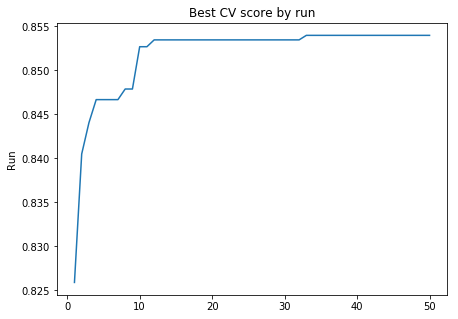

<Figure size 432x288 with 0 Axes>

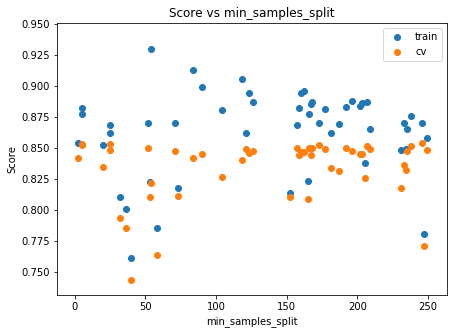

<Figure size 432x288 with 0 Axes>

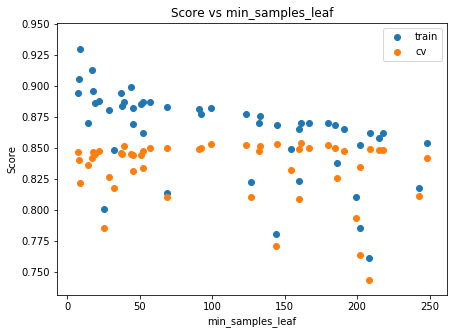

<Figure size 432x288 with 0 Axes>

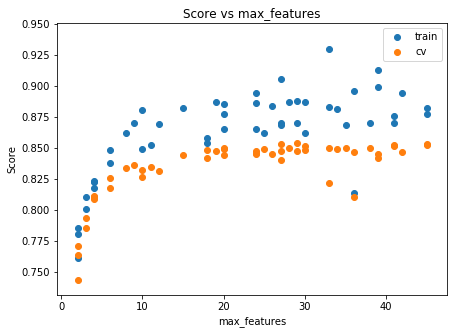

<Figure size 432x288 with 0 Axes>

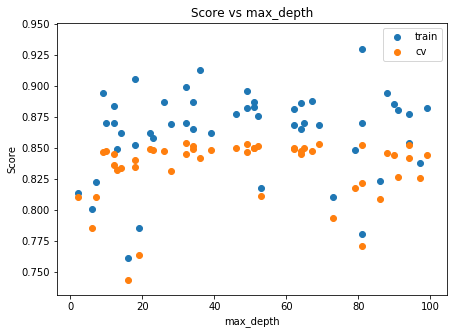

<Figure size 432x288 with 0 Axes>

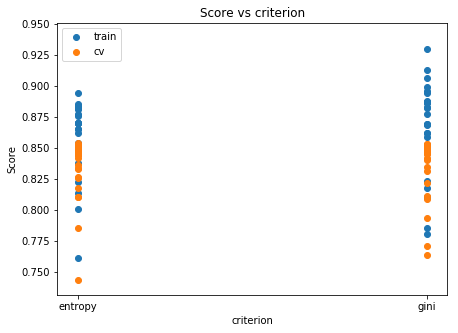

,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,params,valid_score,training_score
32,246,161,29,32,entropy,"{'min_samples_split': 246, 'min_samples_leaf':...",0.853974,0.870175
11,25,145,27,69,gini,"{'min_samples_split': 25, 'min_samples_leaf': ...",0.853460,0.868904
27,5,99,45,49,gini,"{'min_samples_split': 5, 'min_samples_leaf': 9...",0.853232,0.882284
39,173,180,41,81,entropy,"{'min_samples_split': 173, 'min_samples_leaf':...",0.852711,0.870242
9,5,123,45,94,entropy,"{'min_samples_split': 5, 'min_samples_leaf': 1...",0.852684,0.877517
29,238,133,41,52,entropy,"{'min_samples_split': 238, 'min_samples_leaf':...",0.851817,0.875604
15,207,39,30,34,gini,"{'min_samples_split': 207, 'min_samples_leaf':...",0.851746,0.886929
37,192,69,33,51,gini,"{'min_samples_split': 192, 'min_samples_leaf':...",0.850285,0.883161
46,168,57,28,51,gini,"{'min_samples_split': 168, 'min_samples_leaf':...",0.850077,0.887441
31,166,92,20,46,gini,"{'min_samples_split': 166, 'min_samples_leaf':...",0.849916,0.877230


<Figure size 432x288 with 0 Axes>

In [9]:
# Run the random search model
dt_random_search_results, dt_best_params = run_random_search(model=DecisionTreeClassifier(),
                                                             random_grid=dt_random_grid,
                                                             scoring='roc_auc', cv=5, n_iter=50, 
                                                             X_train=X_train, y_train=y_train)

dt_random_search_results.sort_values(by='valid_score', ascending=False).head(25)

In [10]:
# Re-run on best parameters and save model
final_run(X_train, y_train,
          best_params=dt_best_params,
          classifier=DecisionTreeClassifier,
          model_name='decision_tree')

## Random Forest

In [11]:
# Define the grid search parameters
rf_random_grid = {'n_estimators': list(np.arange(20, 3000, 5)),
                   'max_features': list(np.arange(2, X_train.shape[1])),
                   'max_depth': list(np.arange(1, 100)),
                   'min_samples_split': list(np.arange(2, 250)),
                   'min_samples_leaf': list(np.arange(1, 250)),
                   'bootstrap': [True, False]}

In [ ]:
# Run the random search model
rf_random_search_results, rf_best_params = run_random_search(model=RandomForestClassifier(),
                                                            random_grid=rf_random_grid,
                                                            scoring='roc_auc', cv=5, n_iter=50, 
                                                            X_train=X_train, y_train=y_train)

rf_random_search_results.sort_values(by='valid_score', ascending=False).head(25)

In [ ]:
# Re-run on best parameters and save model
final_run(X_train, y_train,
          best_params=rf_best_params,
          classifier=RandomForestClassifier,
          model_name='random_forest')